In [48]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

from ml_functions import RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel
from visual_func import create_testdf, plot_std_lat, plot_residuals

In [2]:
arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_df = pd.read_pickle(arctic_pkl)

In [3]:
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_df = pd.read_pickle(global_pkl)

In [4]:
global_df = global_df.rename(columns={'lat': 'latitude', 'log_N2_sort': 'log_N2'})

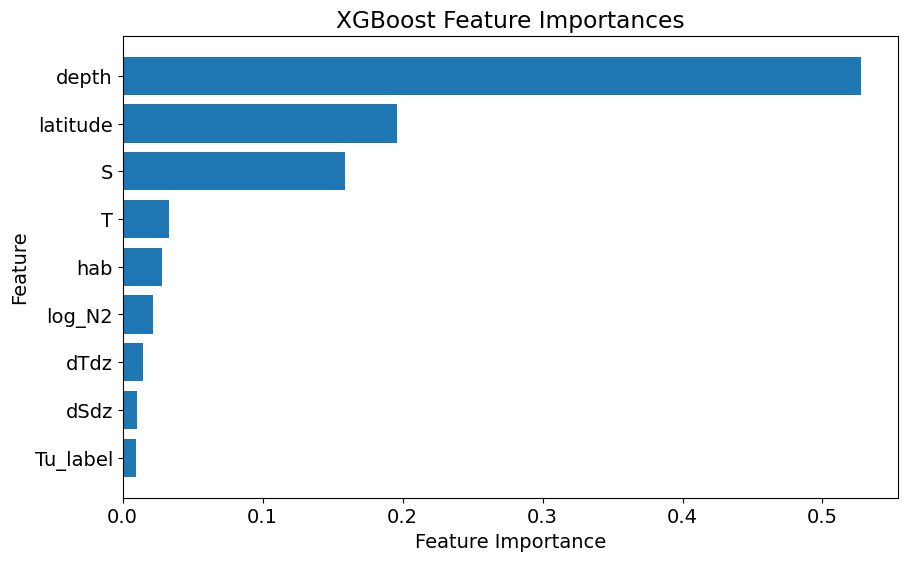

In [5]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']

# We want to predict:
ystringlist = ['log_eps']

xgb_regressor, r2, y_test, y_pred, X_test, feature_importances = XGBoost_regressor(arctic_df, xstringlist , ystringlist)

In [6]:
print(r2)

0.8728543690107291


## Evaluate performance

In [7]:
# Reshape y_pred
y_pred = np.reshape(y_pred, (-1, 1))

In [8]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']

# We want to predict:
ystringlist = ['log_eps']

X_test_df = pd.DataFrame(X_test, columns=xstringlist)
y_test_df = pd.DataFrame(y_test, columns=ystringlist)
y_pred_df = pd.DataFrame(y_pred, columns=['eps_pred'])

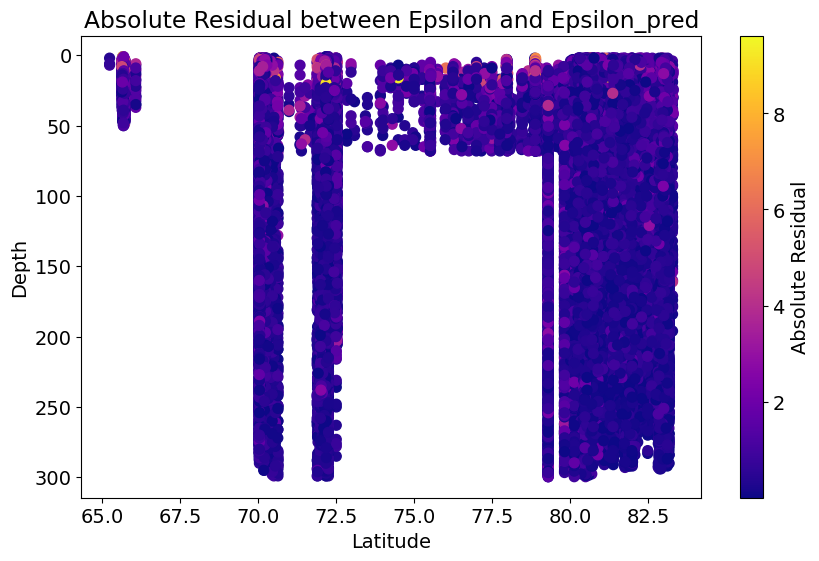

In [9]:
arctic_testdf = create_testdf(X_test_df, y_test_df, y_pred_df)
plot_residuals(arctic_testdf)

In [10]:
residuals = y_test - y_pred

In [11]:
merged_df = arctic_testdf.merge(arctic_df, on=xstringlist+ystringlist)
merged_df = merged_df.drop_duplicates(subset=xstringlist+ystringlist)

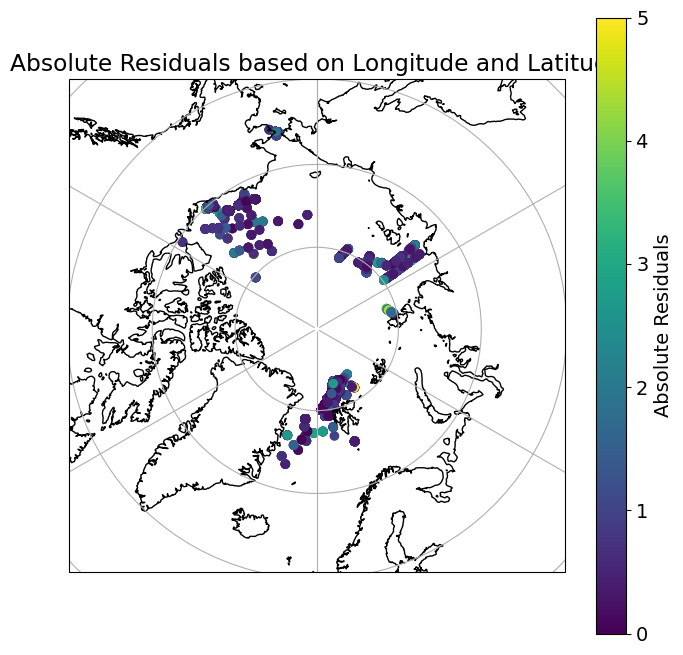

In [37]:
import cartopy.crs as ccrs

# Create a polar stereographic projection centered on the Arctic pole
projection = ccrs.NorthPolarStereo(central_longitude=0)

# Create a figure and axes using the polar stereographic projection
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection})

# Plot longitude and latitude with colored residuals
sc = ax.scatter(merged_df['longitude'], merged_df['latitude'], c=np.abs(residuals), cmap='viridis', vmin=0, vmax=5, transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, label='Absolute Residuals')

# Set map extent to focus on the Arctic region
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.gridlines()

# Set plot title and labels
plt.title('Absolute Residuals based on Longitude and Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

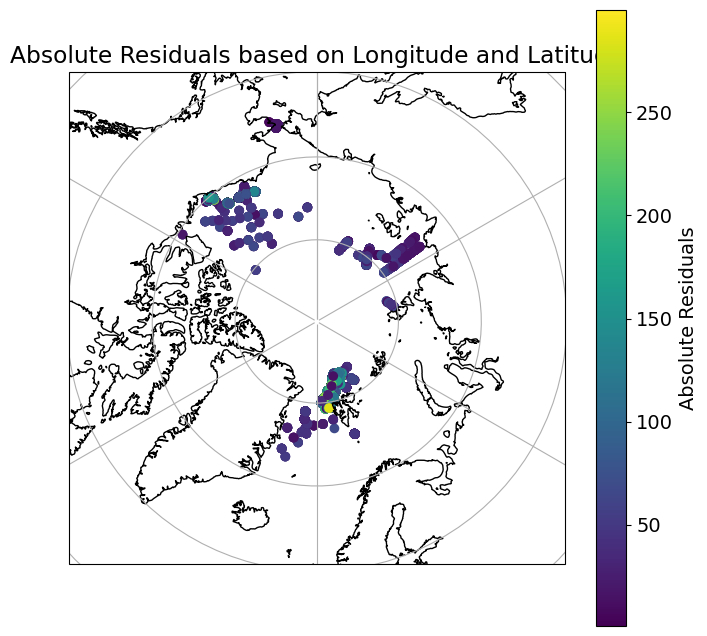

In [40]:
import cartopy.crs as ccrs

# Create a polar stereographic projection centered on the Arctic pole
projection = ccrs.NorthPolarStereo(central_longitude=0)

# Create a figure and axes using the polar stereographic projection
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection})

# Plot longitude and latitude with colored residuals
sc = ax.scatter(merged_df['longitude'], merged_df['latitude'], c=merged_df['depth'], cmap='viridis', transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, label='Absolute Residuals')

# Set map extent to focus on the Arctic region
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.gridlines()

# Set plot title and labels
plt.title('Absolute Residuals based on Longitude and Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [20]:
import numpy as np

# Calculate absolute residuals
absolute_residuals = np.abs(y_test - y_pred)

# Extract the relevant variables from merged_df
depth = merged_df['depth']
latitude = merged_df['latitude']
longitude = merged_df['longitude']
tu_label = merged_df['Tu_label']

# Convert the other variables to numpy arrays
depth = np.array(depth)
latitude = np.array(latitude)
longitude = np.array(longitude)
tu_label = np.array(tu_label)

# Reshape the variables to have compatible dimensions
depth = depth.reshape(-1, 1)  # Reshape to have shape (n_samples, 1)
latitude = latitude.reshape(-1, 1)
longitude = longitude.reshape(-1, 1)
tu_label = tu_label.reshape(-1, 1)

# Concatenate the variables and absolute residuals
data = np.concatenate((depth, latitude, longitude, tu_label, absolute_residuals), axis=1)

# Calculate correlation coefficients
correlation_matrix = np.corrcoef(data, rowvar=False)

# Extract the correlations with absolute residuals
correlation_depth = correlation_matrix[-1, 0]
correlation_latitude = correlation_matrix[-1, 1]
correlation_longitude = correlation_matrix[-1, 2]
correlation_tu_label = correlation_matrix[-1, 3]

print("Correlation with Absolute Residuals:")
print("Depth:", correlation_depth)
print("Latitude:", correlation_latitude)
print("Longitude:", correlation_longitude)
print("Tu Label:", correlation_tu_label)

Correlation with Absolute Residuals:
Depth: -0.2627528279746241
Latitude: -0.13183823797230854
Longitude: -0.08510499101478772
Tu Label: 0.030996252912853704


- depth: the absolute residuals tend to decrease. In other words, there is a weak negative linear relationship between depth and the absolute residuals.
- latitude: The correlation coefficient between latitude and absolute residuals is approximately -0.13. This negative correlation indicates that as latitude increases (moving towards higher latitudes), the absolute residuals tend to decrease. However, the correlation is relatively weak.
- Longitude: The correlation coefficient between longitude and absolute residuals is approximately -0.085. This negative correlation suggests that there is a very weak negative linear relationship between longitude and the absolute residuals. However, the correlation is quite weak, indicating that longitude may not have a strong influence on the absolute residuals.
- Tu Label: The correlation coefficient between tu_label and absolute residuals is approximately 0.031. This positive correlation indicates a weak positive linear relationship between tu_label and the absolute residuals. However, the correlation is quite weak, suggesting that tu_label may not have a strong influence on the absolute residuals.

In [29]:
merged_df["absolute_residuals"] = np.abs(merged_df["log_eps"] - merged_df["eps_pred"])

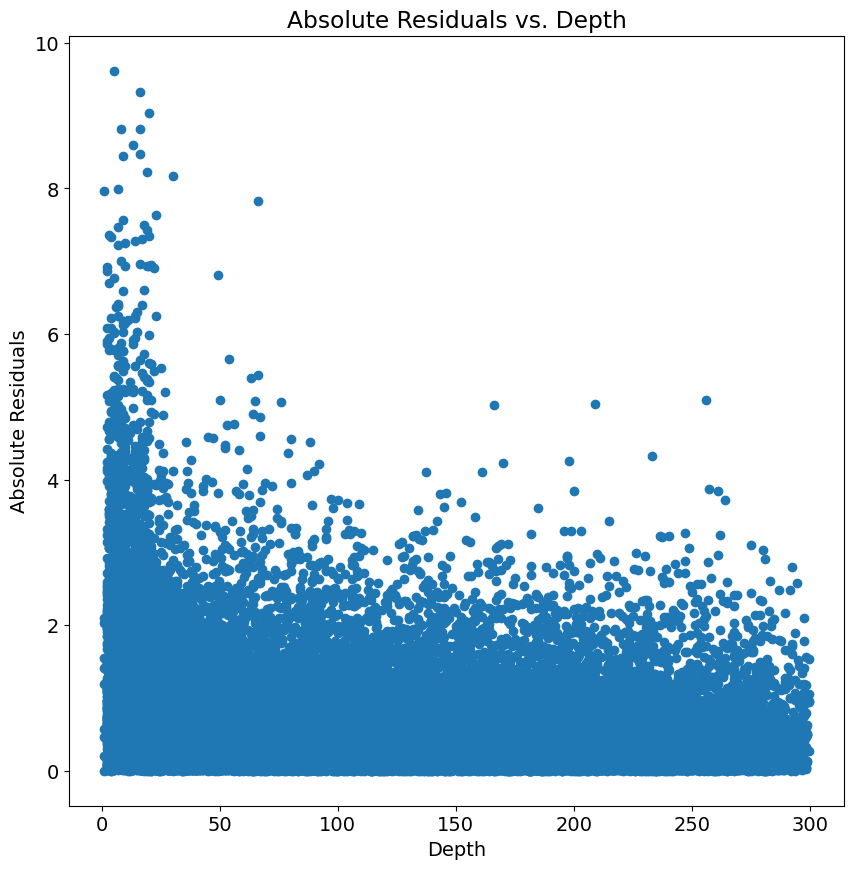

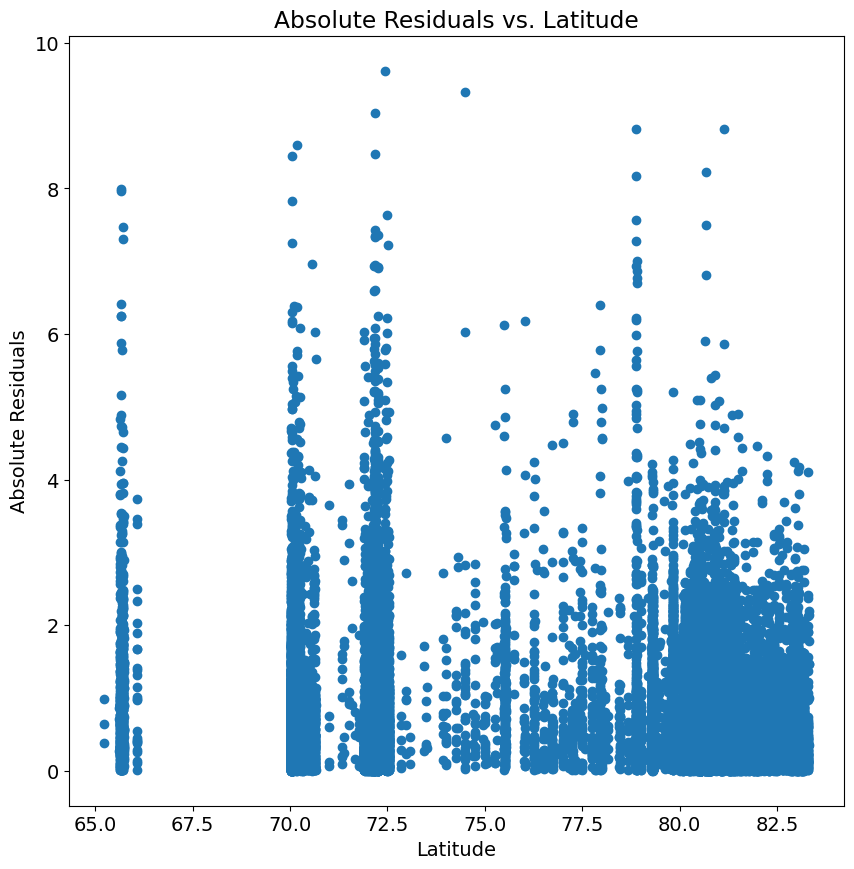

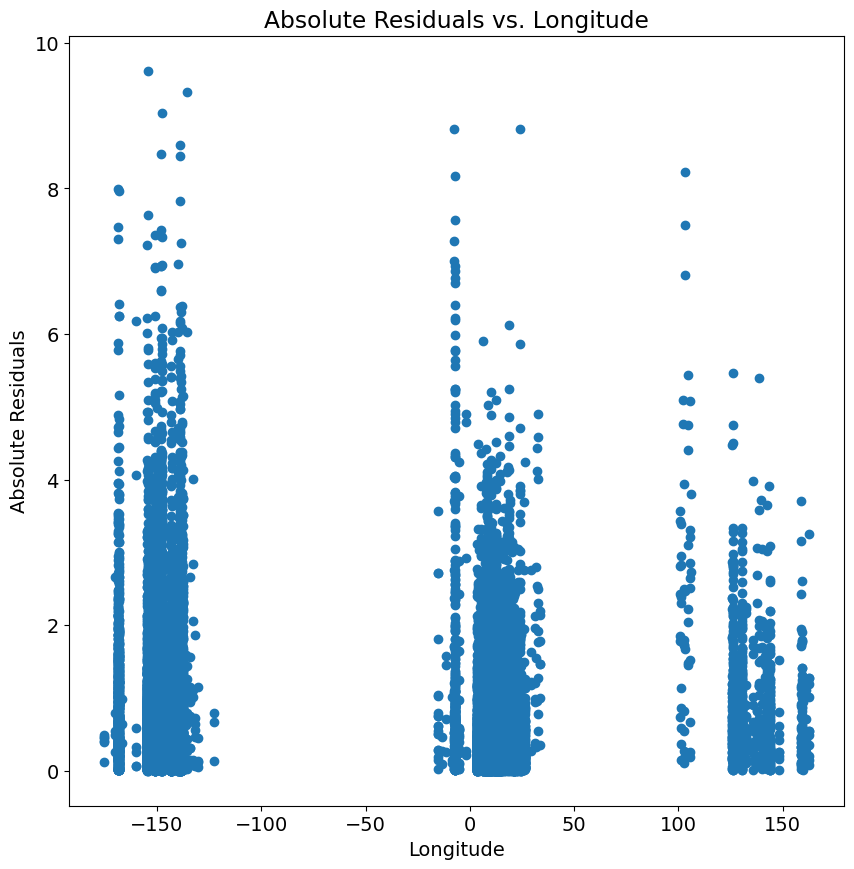

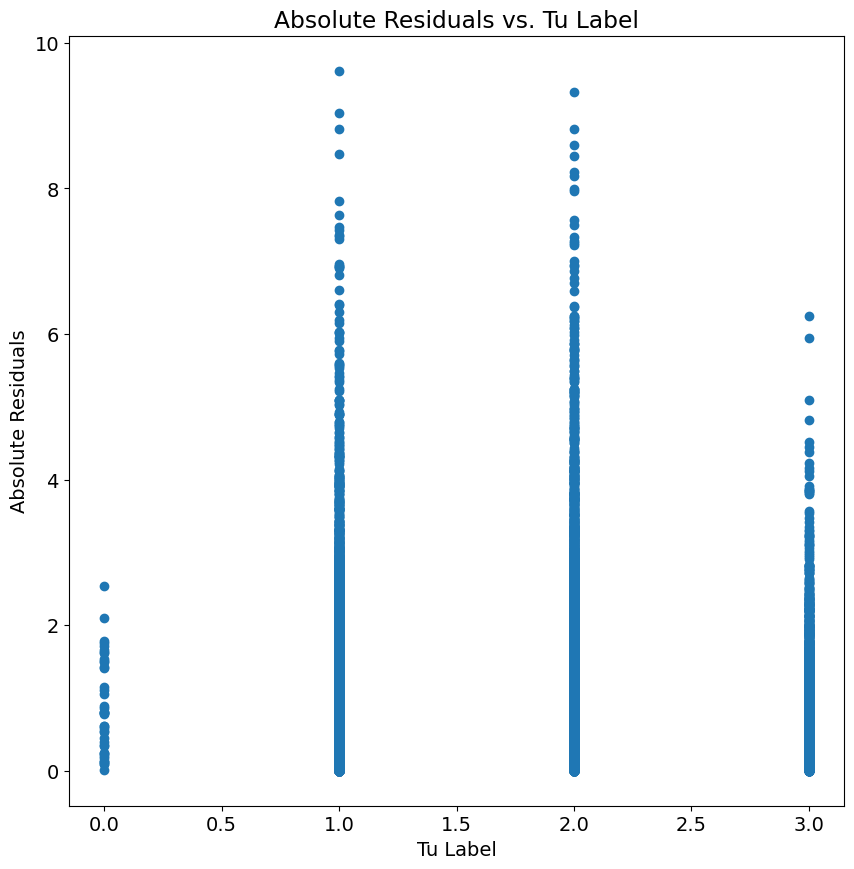

In [39]:
import matplotlib.pyplot as plt

# Scatter plot of Absolute Residuals vs. Depth
plt.scatter(merged_df['depth'], merged_df['absolute_residuals'])
plt.xlabel('Depth')
plt.ylabel('Absolute Residuals')
plt.title('Absolute Residuals vs. Depth')
plt.show()

# Scatter plot of Absolute Residuals vs. Latitude
plt.scatter(merged_df['latitude'], merged_df['absolute_residuals'])
plt.xlabel('Latitude')
plt.ylabel('Absolute Residuals')
plt.title('Absolute Residuals vs. Latitude')
plt.show()

# Scatter plot of Absolute Residuals vs. Longitude
plt.scatter(merged_df['longitude'], merged_df['absolute_residuals'])
plt.xlabel('Longitude')
plt.ylabel('Absolute Residuals')
plt.title('Absolute Residuals vs. Longitude')
plt.show()

# Scatter plot of Absolute Residuals vs. Tu Label
plt.scatter(merged_df['Tu_label'], merged_df['absolute_residuals'])
plt.xlabel('Tu Label')
plt.ylabel('Absolute Residuals')
plt.title('Absolute Residuals vs. Tu Label')
plt.show()


## Hyperparameter tuning

In [52]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def XGBoost_regressor_tuning(dataframe, xfeatures, yfeatures):
    if "Tu_label" in xfeatures:
        hallo = Tu_label(dataframe.Tu)
        dataframe["Tu_label"] = hallo

        dataframe = encode_tulabel(dataframe)

    if 'log_eps' not in dataframe.columns:
        dataframe['log_eps'] = dataframe['eps'].apply(lambda x: math.log(x))

    # Stop depth at 300m
    dataframe = dataframe[dataframe["depth"] <= 300]

    x = dataframe[xfeatures].values
    y = dataframe[yfeatures].values

    # Split into train and test sets
    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

    # Define the parameter grid for grid search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001]
    }

    # Define the XGBoost regressor
    xgb_regressor = xgb.XGBRegressor(random_state=SEED)

    # Perform grid search
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)

    # Plot feature importances
    feature_importances = best_model.feature_importances_
    sorted_indices = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
    plt.yticks(range(len(feature_importances)), [xfeatures[i] for i in sorted_indices])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importances')
    plt.show()

    return best_model, r2, y_test, y_pred, X_test, feature_importances, best_params


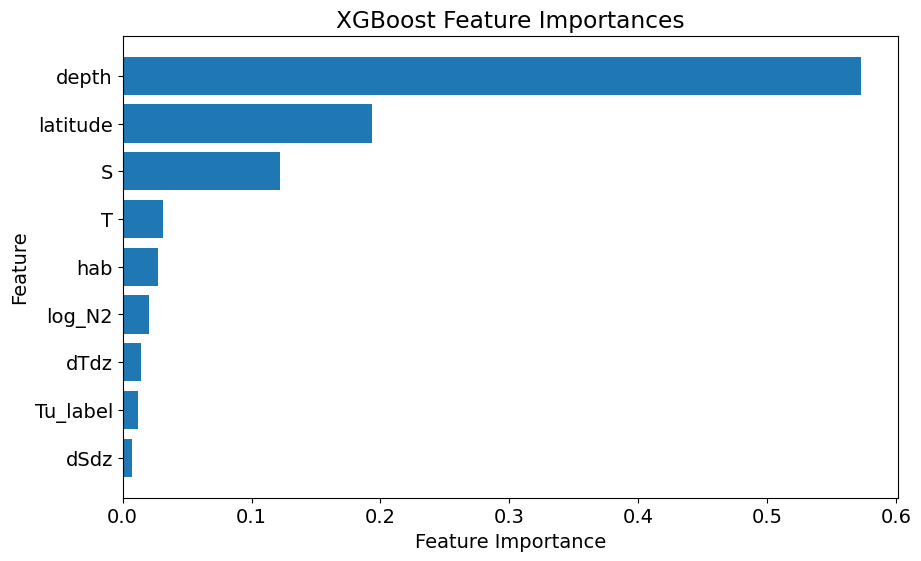

ValueError: too many values to unpack (expected 6)

In [53]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']

# We want to predict:
ystringlist = ['log_eps']

best_model, r2_tune, y_test_tune, y_pred_tune, X_test_tune, feature_importances_tune, best_params = XGBoost_regressor_tuning(arctic_df, xstringlist , ystringlist)

In [ ]:
# Save the best_model
with open('models/best_model_arctic_xbg.pickle', 'wb') as file:
    pickle.dump(best_model, file)
    
best_model_params = best_model.get_params()
print(best_model_params)

## Do global model as well

In [ ]:
# Features:
xstringlist_g = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2']

# We want to predict:
ystringlist_g = ['log_eps']

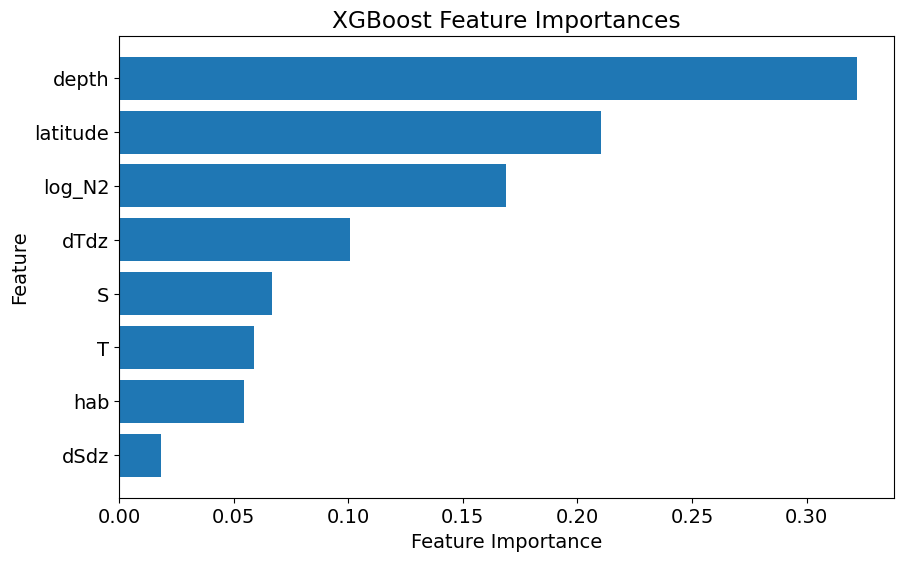

In [28]:
global_xgb_regressor, global_r2, global_y_test, global_y_pred, global_X_test, global_feature_importances = XGBoost_regressor(global_df, xstringlist , ystringlist)

In [29]:
print(global_r2)

0.6339672666621631


In [ ]:
best_model_g, r2_tune_g, y_test_tune_g, y_pred_tune_g, X_test_tune_g, feature_importances_tune_g = XGBoost_regressor_tuning(global_df, xstringlist_g, ystringlist_g)

In [ ]:
print(r2_tune_g)

In [ ]:
# Save the best_model
with open('models/best_model_global_xbg.pickle', 'wb') as file:
    pickle.dump(best_model_g, file)
    
best_model_params_g = best_model.get_params()
print(best_model_params_g)

### use this model to predict epsilon for arctic_df

In [30]:
# Make predictions on arctic_df using global_xgb_regressor
arctic_X_test = arctic_df[xstringlist].values
arctic_y_pred = global_xgb_regressor.predict(arctic_X_test)

# Evaluate the predictions on arctic_df using global_y_test
arctic_y_test = arctic_df[ystringlist].values
arctic_r2 = r2_score(arctic_y_test, arctic_y_pred)

# Get feature importances for arctic_df
arctic_feature_importances = global_xgb_regressor.feature_importances_

In [31]:
print("Using global XGboost model on arctic data", arctic_r2)

-25.789339171054312

# perform model on both arctic and on global

In [16]:
import math
arctic_df['log_eps'] = arctic_df['eps'].apply(lambda x: math.log(x))

In [15]:
global_df = global_df.rename(columns={'z': 'depth', 'lat': 'latitude', 'log_N2_sort': 'log_N2'})

In [19]:
concatenated_df = pd.concat([global_df, arctic_df], axis=0)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects